In [34]:
from libraries.db import DatabaseProxy
from bertopic import BERTopic
import dotenv
from bertopic.representation import OpenAI, KeyBERTInspired
import openai
import os
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
db = DatabaseProxy(reset=True, database="eda")
dotenv.load_dotenv(".envrc")

True

In [36]:
df = pd.read_csv("input/qa-pairs.csv", encoding="latin-1")
db.insert_from_dataframe(df, col_questions="question", col_answers="answer")

# Basic Statistics

In [37]:
df.head()

question  \
0  Checking the financial stability of our suppli...   
1  How many candidates do you have in your database?   
2  How do you select which candidates are placed ...   
3  How often do you review and refresh your datab...   
4  What type of background and drug testing do yo...   

                                              answer  \
0  Our fiscal year begins in January and ends in ...   
1  As of today, 4/25/2023, we have the following:...   
2  Our specialized role known as the client speci...   
3  Our sourcing platform is updated throughout th...   
4  AccuSource is our service provider for backgro...   

   partners_personnel_selected  
0                            0  
1                            0  
2                            0  
3                            0  
4                            0

Number of questions

In [38]:
df.shape

(168, 3)

Question length (character and word count)

In [39]:
df["question_length"] = df["question"].apply(len)
df["question_wordcount"] = df["question"].apply(lambda x: len(x.split(" ")))

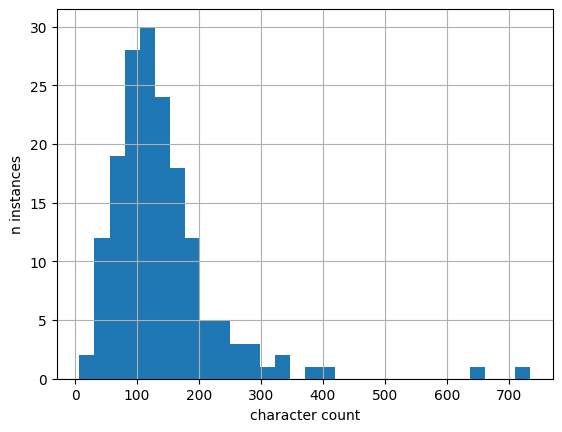

count    168.000000
mean     140.869048
std       91.372539
min        7.000000
25%       91.500000
50%      123.000000
75%      163.750000
max      735.000000
Name: question_length, dtype: float64

In [40]:
df["question_length"].hist(bins=30)
plt.xlabel("character count")
plt.ylabel("n instances")
plt.show()
df["question_length"].describe()

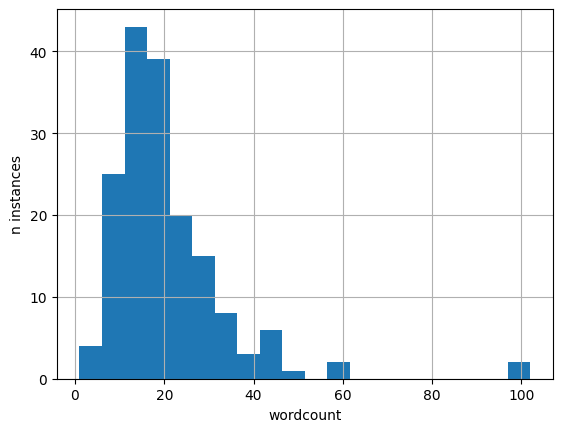

count    168.000000
mean      21.059524
std       13.481725
min        1.000000
25%       14.000000
50%       18.000000
75%       25.000000
max      102.000000
Name: question_wordcount, dtype: float64

In [41]:
df["question_wordcount"].hist(bins=20)
plt.xlabel("wordcount")
plt.ylabel("n instances")
plt.show()
df["question_wordcount"].describe()

Bundled question distribution

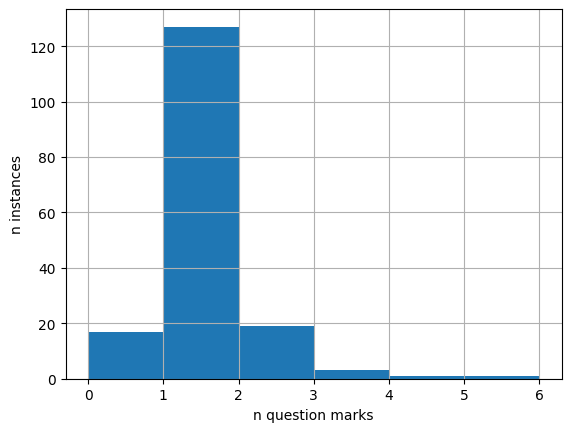

count    168.000000
mean       1.095238
std        0.694185
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        6.000000
Name: n_bundled_questions, dtype: float64

In [42]:
df["n_bundled_questions"] = df["question"].apply(lambda x: x.count("?"))
df["n_bundled_questions"].hist(bins=6)
plt.xlabel("n question marks")
plt.ylabel("n instances")
plt.show()
df["n_bundled_questions"].describe()

# Named Entity Recognizer

In [43]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [44]:
for i, row in df.iterrows():
    question = row["question"]
    doc = nlp(question)
    print(question)
    for ent in doc.ents:
        print(ent, ent.label_)
    if i > 5:
        break

Checking the financial stability of our suppliers is part of our due diligence process. To support us in doing this, please tell us when your company financial year runs to and from.
year DATE
How many candidates do you have in your database?
How do you select which candidates are placed where?  For instance, if two buyers are looking for the same candidate, how do you ultimately determine which company to place that employee with?
two CARDINAL
How often do you review and refresh your database of candidates?
What type of background and drug testing do you conduct?  How extensive are they? Who is your service provider for background checking?
What questions do you use during the interview process?  Please provide several examples and elaborate on your evaluation technique.  May Michaels submit questions in addition to your own?
Please advise how Michaels will be utilized in the hiring and onboarding process.  For example, who provides the approvals and onboarding training?
Michaels NORP

# Topic Modeling

Uses LDA according to the following article: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

Clean data

In [45]:
df_lda = pd.DataFrame(df[["question", "answer"]])

In [46]:
# Load the regular expression library
import re

# Remove punctuation
df_lda["question_processed"] = df_lda["question"].map(
    lambda x: re.sub("[,\.!?]", "", x)
)
# Convert the titles to lowercase
df_lda["question_processed"] = df_lda["question_processed"].map(lambda x: x.lower())
# remove extraneous whitespace
df_lda["question_processed"] = df_lda["question_processed"].str.strip()
# Print out the first rows of papers
df_lda["question_processed"].head()

<>:6: DeprecationWarning: invalid escape sequence '\.'
<>:6: DeprecationWarning: invalid escape sequence '\.'
/var/folders/hj/fvn4xm956vz081jjs4b_68hr0000gn/T/ipykernel_1268/3506479410.py:6: DeprecationWarning: invalid escape sequence '\.'
  lambda x: re.sub("[,\.!?]", "", x)


0    checking the financial stability of our suppli...
1     how many candidates do you have in your database
2    how do you select which candidates are placed ...
3    how often do you review and refresh your datab...
4    what type of background and drug testing do yo...
Name: question_processed, dtype: object

Create wordcloud

/Users/kalebsmith/ownCloud/school/cs-482/Partners-Personnel-Capstone-Project/.venv/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


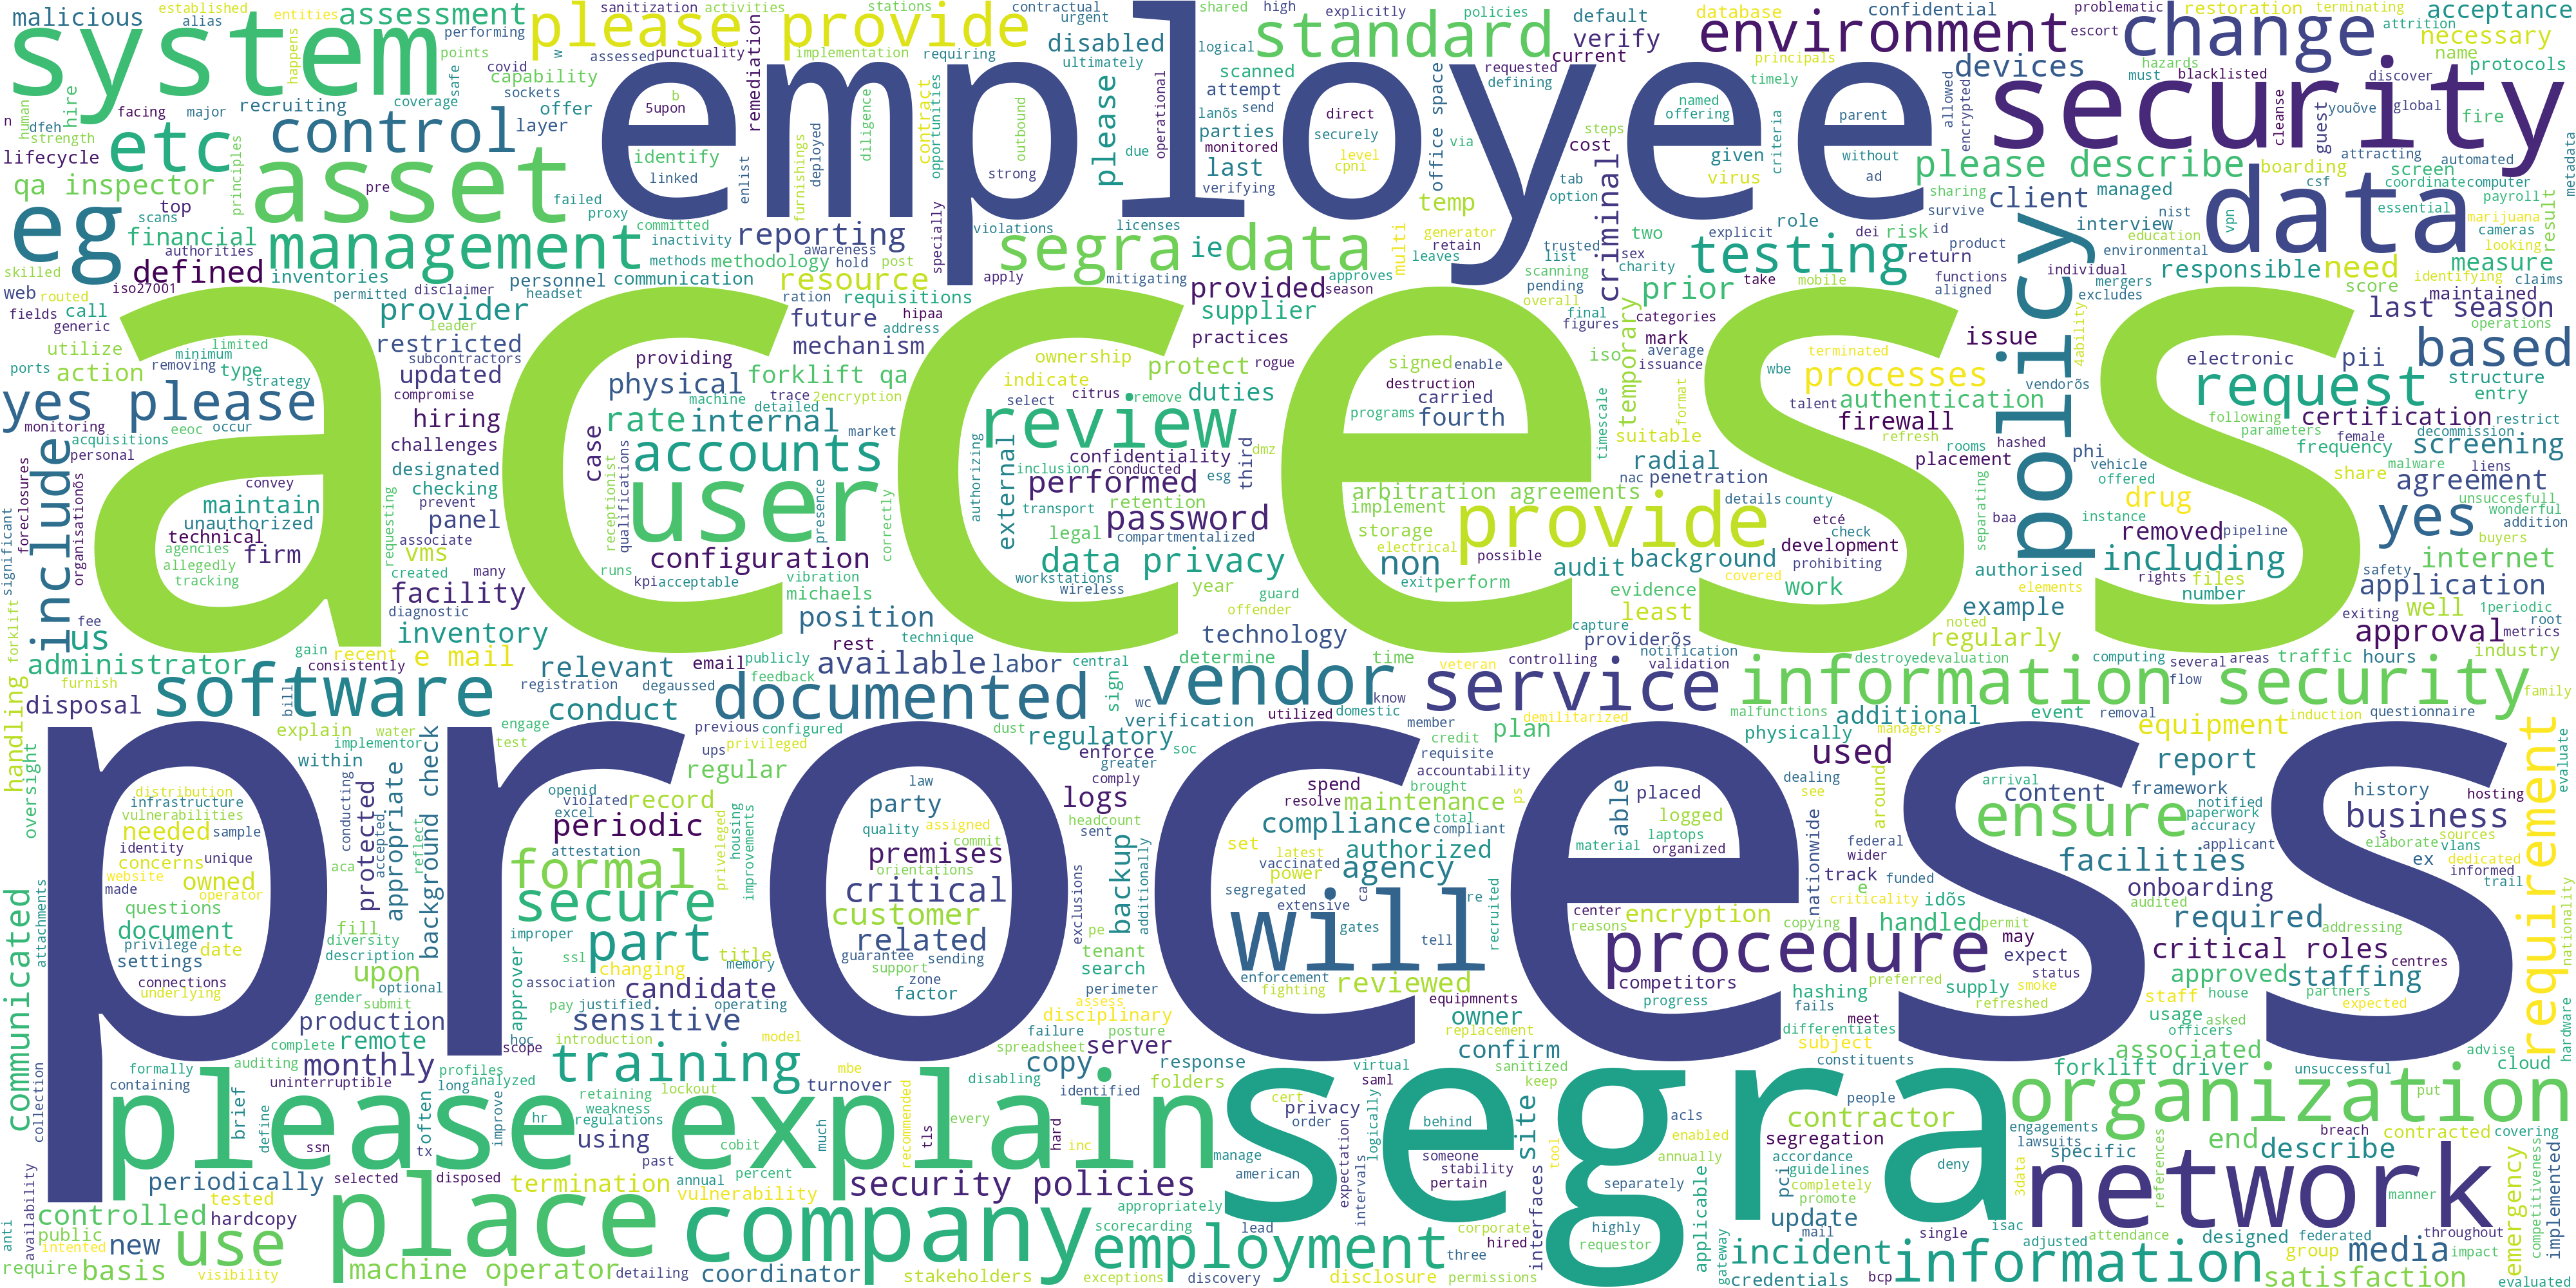

In [47]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ",".join(list(df_lda["question_processed"].values))
# Create a WordCloud object
wordcloud = WordCloud(
    background_color="white",
    width=4000,
    height=2000,
    max_words=5000,
    contour_width=3,
    contour_color="steelblue",
)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

Prepare data for LDA analysis

In [48]:
from gensim.utils import simple_preprocess

# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords


stop_words = stopwords.words("english")
stop_words.extend(["from", "subject", "re", "edu", "use"])


def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield (simple_preprocess(str(sentence), deacc=True))


def remove_stopwords(texts):
    return [
        [word for word in simple_preprocess(str(doc)) if word not in stop_words]
        for doc in texts
    ]


data = df_lda["question_processed"].values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['checking', 'financial', 'stability', 'suppliers', 'part', 'due', 'diligence', 'process', 'support', 'us', 'please', 'tell', 'us', 'company', 'financial', 'year', 'runs']


In [49]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1)]


LDA model training

In [50]:
import gensim
from pprint import pprint

# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(
    corpus=corpus, id2word=id2word, num_topics=num_topics
)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.027*"data" + 0.021*"information" + 0.021*"please" + 0.017*"documented" + '
  '0.015*"security" + 0.014*"policy" + 0.014*"privacy" + 0.011*"place" + '
  '0.010*"communicated" + 0.009*"non"'),
 (1,
  '0.027*"please" + 0.027*"data" + 0.021*"security" + 0.019*"explain" + '
  '0.013*"process" + 0.013*"management" + 0.013*"yes" + 0.011*"privacy" + '
  '0.010*"encryption" + 0.008*"related"'),
 (2,
  '0.020*"please" + 0.011*"process" + 0.011*"describe" + 0.011*"employees" + '
  '0.011*"us" + 0.011*"security" + 0.011*"documented" + 0.010*"review" + '
  '0.010*"employment" + 0.009*"part"'),
 (3,
  '0.024*"please" + 0.022*"explain" + 0.021*"segra" + 0.018*"data" + '
  '0.018*"access" + 0.015*"network" + 0.012*"systems" + 0.012*"place" + '
  '0.011*"users" + 0.011*"process"'),
 (4,
  '0.024*"process" + 0.018*"security" + 0.013*"segra" + 0.012*"access" + '
  '0.012*"place" + 0.009*"used" + 0.009*"please" + 0.009*"internal" + '
  '0.009*"etc" + 0.008*"periodic"'),
 (5,
  '0.019*"please" + 

Analyzing LDA results

In [51]:
import pyLDAvis.gensim
import pickle
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join("./output/ldavis_prepared_" + str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, "wb") as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, "rb") as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(
    LDAvis_prepared, "./output/ldavis_prepared_" + str(num_topics) + ".html"
)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.088627 -0.076665       1        1  13.024327
5     -0.023444  0.067415       2        1  12.762580
8     -0.098593  0.019239       3        1  12.160260
4      0.040177  0.070534       4        1  10.256876
0      0.043404  0.011718       5        1  10.039580
9      0.015417 -0.092700       6        1   9.976973
1      0.104139  0.006242       7        1   9.836491
2     -0.061942  0.052621       8        1   9.323702
7     -0.107365 -0.102329       9        1   7.768861
6     -0.000420  0.043925      10        1   4.850351, topic_info=            Term       Freq      Total Category  logprob  loglift
86   information  13.000000  13.000000  Default  30.0000  30.0000
243         data  25.000000  25.000000  Default  29.0000  29.0000
432     critical   6.000000   6.000000  Default  28.0000  28.0000
234     security  25.000000  25.000000  Default  27.0000  27.0000
287       assets   7.000000   7.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
335       formal   0.606278   5.587767  Topic10  -5.1405   0.8051
400  maintenance   0.606276   2.676672  Topic10  -5.1405   1.5411
6         please   0.606272  36.780350  Topic10  -5.1405  -1.0793
83       actions   0.606268   2.001260  Topic10  -5.1405   1.8319
364   employment   0.606268   6.984048  Topic10  -5.1405   0.5821

[603 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
192       1  0.386545    able
192       9  0.386545    able
211       1  0.222818  access
211       2  0.222818  access
211       3  0.044564  access
...     ...       ...     ...
82        5  0.180152     yes
82        6  0.180152     yes
82        7  0.270229     yes
82        8  0.090076     yes
527       1  0.681635    zone

[826 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 9, 5, 1, 10, 2, 3, 8, 7])

# bertopic

In [52]:
questions = [q.text for q in db.get_questions()]

In [53]:
questions[:5]

['Checking the financial stability of our suppliers is part of our due diligence process. To support us in doing this, please tell us when your company financial year runs to and from.',
 'How many candidates do you have in your database?',
 'How do you select which candidates are placed where?  For instance, if two buyers are looking for the same candidate, how do you ultimately determine which company to place that employee with?',
 'How often do you review and refresh your database of candidates?',
 'What type of background and drug testing do you conduct?  How extensive are they? Who is your service provider for background checking?']

In [54]:
# Fine-tune topic representations with GPT
representation_model = KeyBERTInspired()
topic_model = BERTopic(representation_model=representation_model)
topics, probs = topic_model.fit_transform(questions)

/Users/kalebsmith/ownCloud/school/cs-482/Partners-Personnel-Capstone-Project/.venv/lib/python3.11/site-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


In [55]:
topic_model.get_topic_info()

Topic  Count                                          Name  \
0     -1     75  -1_termination_employees_employee_procedures   
1      0     28     0_privacy_compliance_security_regulations   
2      1     25              1_staffing_forklift_hiring_roles   
3      2     25         2_providers_segra_facilities_services   
4      3     15   3_permissions_security_privileged_privilege   

                                      Representation  \
0  [termination, employees, employee, procedures,...   
1  [privacy, compliance, security, regulations, p...   
2  [staffing, forklift, hiring, roles, qa, turnov...   
3  [providers, segra, facilities, services, servi...   
4  [permissions, security, privileged, privilege,...   

                                 Representative_Docs  
0  [What is your process for auditing employee on...  
1  [Is  a regulatory data privacy and data securi...  
2  [If you were a provider of ours last season wh...  
3  [Is the network used for providing service to ...  
4  [Is two factor authentication required to acce...

In [56]:
for _, row in topic_model.get_topic_info().iterrows():
    print(row["Name"], row["Count"])
    for doc in row["Representative_Docs"]:
        print(f"\t-{doc.strip()}")
    print()

-1_termination_employees_employee_procedures 75
	-What is your process for auditing employee onboarding paperwork to ensure arbitration agreements are signed?
Where do you maintain the arbitration agreements and for how long? 
What is the process for requesting the documents if/when needed?
	-Is there procedures in place for handling secure disposal and or return of the customer data upon request or in the case of termination of services? Please explain
	-Is there a process in place to ensure all employees and external users return the organization's assets on termination of their employment, contract or agreement?

0_privacy_compliance_security_regulations 28
	-Is  a regulatory data privacy and data security compliance assessment against the applicable global and domestic data privacy and data security related regulations performed regularly? If Yes, what is the current status of the compliance assessment noted above? Please provide evidence
	-Does your organization have a documented 